# Deploying a project for offline inference

In this notebook, we will show how to create a deployment for a project that can be used to run inference locally, using OpenVINO.

In [1]:
# As usual we will connect to the platform first, using the server details from the .env file

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

2023-08-24 16:54:20,131 - INFO - Authenticating on host https://192.168.0.175...
2023-08-24 16:54:20,217 - INFO - Authentication successful. Cookie received.


C:\Users\pjram\geti_env\lib\site-packages\geti_sdk\http_session\geti_session.py:71: InsecureRequestWarning: You have disabled TLS certificate validation, HTTPS requests made to the Intel® Geti™ server may be compromised. For optimal security, please enable certificate validation.
  warnings.warn(


### Selecting a project for deployment
Let's list all projects in the workspace and select one for which to create a deployment

In [2]:
from geti_sdk.rest_clients import ProjectClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)
projects = project_client.list_projects()

4 projects were found on the platform:

 Project: Cubes_ObjectDetection
  Task 1: Detection task
    Labels: ['No Object', 'Defect']


 Project: Cubes_Classification
  Task 1: Classification task
    Labels: ['Good', 'Bad']


 Project: Cube_AnomalyClass
  Task 1: Anomaly classification task
    Labels: ['Normal', 'Anomalous']


 Project: person-bike-car
  Task 1: Detection task
    Labels: ['person', 'car', 'bike', 'No Object']




## Deploying the project
Let's go with the project we created in notebook [004](004_create_pipeline_project_from_dataset.ipynb): `COCO multitask animal demo`. To create a deployment, we can use the `geti.deploy_project` convenience method. This will download the active (OpenVINO) models for all tasks in the project to our local machine, so that we can use them to run inference locally.

> **NOTE**: Downloading the model data may take some time, especially models for anomaly tasks are on the order of 100 Mb in size so please be prepared to wait a bit

In [3]:
PROJECT_NAME = "Cube_AnomalyClass"

Before deploying, we need to make sure that the project is trained. Otherwise it will not contain any models to deploy, and the deployment will fail.

In [4]:
from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);


Project 'Cube_AnomalyClass' is ready to predict.



Once we are sure that the project has trained models for each task, we can create the deployment in the cell below.

In [5]:
deployment = geti.deploy_project(project_name=PROJECT_NAME)

2023-08-24 16:54:46,656 - INFO - Deployment for project 'Cube_AnomalyClass' started.
2023-08-24 16:54:46,664 - INFO - Waiting for the deployment to be created...
2023-08-24 16:54:51,886 - INFO - Downloading project deployment archive...
2023-08-24 16:54:53,296 - INFO - Deployment for project 'Cube_AnomalyClass' downloaded and extracted successfully.


### Preparing the models for inference
Now that the `deployment` is created and the models are saved to the local disk, we can load the models into memory to prepare them for inference. 

In [6]:
deployment.load_inference_models(device="CPU")

2023-08-24 16:54:58,780 - INFO - OpenVINO Runtime
2023-08-24 16:54:58,780 - INFO - 	build: 2022.3.0-9052-9752fafe8eb-releases/2022/3
2023-08-24 16:54:58,784 - INFO - Reading model C:\Users\pjram\AppData\Local\Temp\tmpzikxjkzf\deployment\Anomaly classification task\model\model.xml
2023-08-24 16:55:01,082 - INFO - The model C:\Users\pjram\AppData\Local\Temp\tmpzikxjkzf\deployment\Anomaly classification task\model\model.xml is loaded to CPU
2023-08-24 16:55:01,084 - INFO - 	Device: CPU
2023-08-24 16:55:01,086 - INFO - 		Number of streams: 1
2023-08-24 16:55:01,088 - INFO - 		Number of threads: AUTO
2023-08-24 16:55:01,089 - INFO - 	Number of model infer requests: 1
2023-08-24 16:55:01,090 - INFO - Inference models loaded on device `CPU` successfully.


## Running inference on an image locally
Now, we can load an image as a numpy array (for instance using OpenCV) and use the `deployment.infer` method to generate a prediction for it.
The SDK contains an example image that we use for this. The path to the image is in the `EXAMPLE_IMAGE_PATH` constant, from the `geti_sdk.demos` module.

In [8]:
import time

import cv2

from geti_sdk.demos import EXAMPLE_IMAGE_PATH

numpy_image = cv2.imread("C:/Users/pjram/Downloads/cubes/cubes/abnormal/input_20230210134128.jpg")

# Convert to RGB channel order. All deployed models expect the image in RGB format
numpy_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

t_start = time.time()
prediction = deployment.infer(numpy_rgb)
t_elapsed = time.time() - t_start

print(f"Running local inference on image took {t_elapsed*1000:.2f} milliseconds")

Running local inference on image took 39.31 milliseconds


### Inspecting the result
The `Prediction` object generated by `deployment.infer` is equal in structure to the predictions sent by the platform. So let's have a closer look at it. We can do so in two ways: 

1. Visualise it using the `show_image_with_annotation_scene` utility function
2. Inspecting its properties via the `prediction.overview` property

Let's show it on the image first

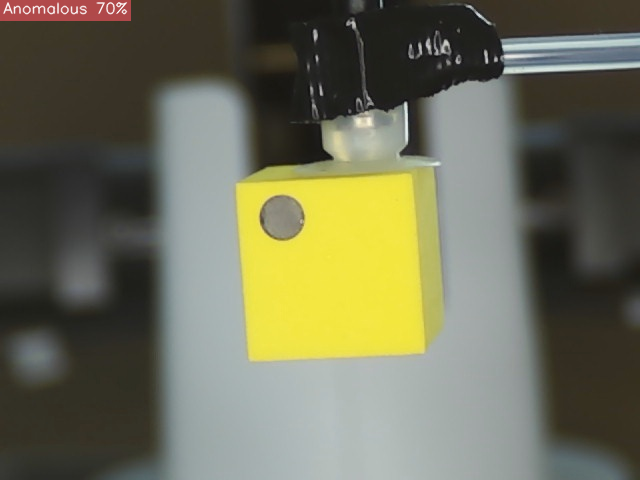

In [9]:
from geti_sdk.utils import show_image_with_annotation_scene

show_image_with_annotation_scene(numpy_rgb, prediction, show_in_notebook=True);

In [ ]:
print(prediction.overview)

## Saving the deployment
When we create the deployment, the model data is saved to a temporary folder. We store the deployment for offline re-use later on by saving it: This will copy the model data from the temporary folder to the path we specify. If we want to run inference locally again, we can simply reload the deployment from the saved folder, without having to connect to the platform again.

In [10]:
import os

PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME)

deployment.save(path_to_folder=PATH_TO_DEPLOYMENT_FOLDER)

True

## Loading a saved deployment
Loading a deployment that was previously saved to disk is easy and can be done without establishing a connection to the platform (or without even connecting to the internet, for that matter).

In [11]:
from geti_sdk.deployment import Deployment

offline_deployment = Deployment.from_folder(PATH_TO_DEPLOYMENT_FOLDER)

Again, to prepare the deployment for inference make sure to send the models to CPU (or whichever device you want to use)

In [12]:
offline_deployment.load_inference_models(device="CPU")

2023-08-24 16:55:57,989 - INFO - OpenVINO Runtime
2023-08-24 16:55:57,991 - INFO - 	build: 2022.3.0-9052-9752fafe8eb-releases/2022/3
2023-08-24 16:55:57,993 - INFO - Reading model deployments\Cube_AnomalyClass\deployment\Anomaly classification task\model\model.xml
2023-08-24 16:55:58,495 - INFO - The model deployments\Cube_AnomalyClass\deployment\Anomaly classification task\model\model.xml is loaded to CPU
2023-08-24 16:55:58,498 - INFO - 	Device: CPU
2023-08-24 16:55:58,500 - INFO - 		Number of streams: 1
2023-08-24 16:55:58,501 - INFO - 		Number of threads: AUTO
2023-08-24 16:55:58,503 - INFO - 	Number of model infer requests: 1
2023-08-24 16:55:58,506 - INFO - Inference models loaded on device `CPU` successfully.


That's all there is to it! The `offline_deployment` can now be used to run inference.

# Comparing local inference and inference on the platform
As a final step, we can make a comparison between the local inference results and the predictions sent back from the platform. We will have a look at the time required for both methods, and compare the output.

In [13]:
from geti_sdk.rest_clients import ImageClient, PredictionClient

project = project_client.get_project_by_name(PROJECT_NAME)

image_client = ImageClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)
prediction_client = PredictionClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

To prepare for platform inference, we have to upload the image to the platform first

In [14]:
sc_image = image_client.upload_image(numpy_image)
# Load the pixel data to visualize the image later on
sc_image.get_data(geti.session);

### Comparing inference times
Now, we can run inference locally and on the platform, and time both. We will set the prediction client to `ONLINE` mode, which means it will always generate a new prediction for the image, rather than returning cached predictions. Additionally you can set the mode to `AUTO` (which will return cached predictions if available) and re-run the cell to see the difference.

In [15]:
from geti_sdk.data_models.enums import PredictionMode

prediction_client.mode = PredictionMode.ONLINE

# Get platform prediction, and measure time required
t_start_platform = time.time()
platform_prediction = prediction_client.get_image_prediction(sc_image)
t_elapsed_platform = time.time() - t_start_platform

# Get local prediction, and measure time required
t_start_local = time.time()
local_prediction = offline_deployment.infer(numpy_rgb)
t_elapsed_local = time.time() - t_start_local

print(f"Platform prediction completed in {t_elapsed_platform*1000:.1f} milliseconds")
print(f"Local prediction completed in {t_elapsed_local*1000:.1f} milliseconds")

Platform prediction completed in 119.0 milliseconds
Local prediction completed in 29.2 milliseconds


### Comparing inference results
The cell below will show the results from the platform prediction (top) and local prediction (bottom). The two predictions should be equal.

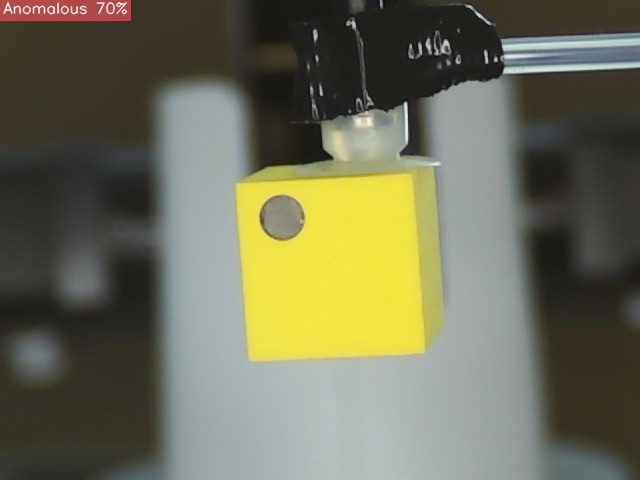

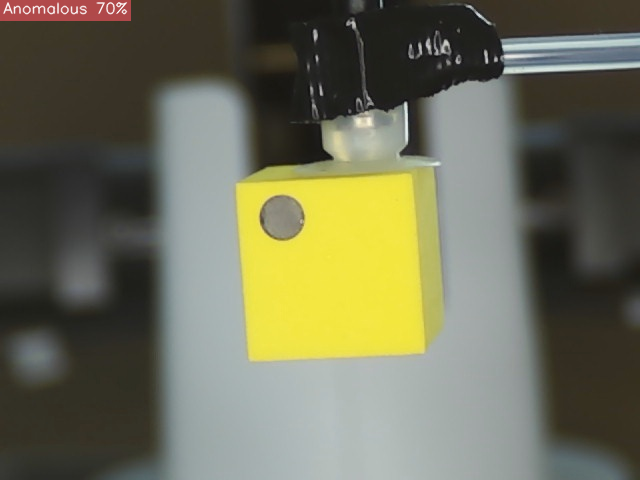

In [16]:
show_image_with_annotation_scene(
    sc_image, platform_prediction, show_in_notebook=True, channel_order="bgr"
)
show_image_with_annotation_scene(numpy_rgb, local_prediction, show_in_notebook=True);

### Cleaning up
To clean up, we will delete the sc_image from the project again

In [ ]:
image_client.delete_images([sc_image])